# Reproducing JPM’s US Rates Strategy RV Trade Idea 
## Note - `Treasuries: The first cut is the deepest` (20 September 2024)
## `91:100 3.125% Nov-41/ 2% Nov-41 flattener`

```
Turning to relative value, we’ve noticed that originally issued 20-year bonds maturing in late-2041 and early-2042 have cheapened relative to our par curve, whereas originally issued 30-year bonds with similar maturities have outperformed. Clearly, the recent steepening of the Treasury curve supports wider yield spreads between higher-coupon OI 30s, and lower-coupon OI 20s with the same maturity, given significant duration differences. However, this dynamic is not explained by duration profiles: Figure 20 displays the securities in the 2040–2043 basket, sorted by modified duration and shows that late-41/ early-42 OI 30s appear rich relative to other securities with similar duration. In particular, the 3.125% Nov-41/ 2% Nov-41 curve appears 5.0bp too steep relative to the shape of the 15s/20s Treasury par curve (Figure 21). Hence, we recommend initiating 91:100 weighted 3.125% Nov-41/ 2% Nov-41 flatteners (see Trade recommendations).
```

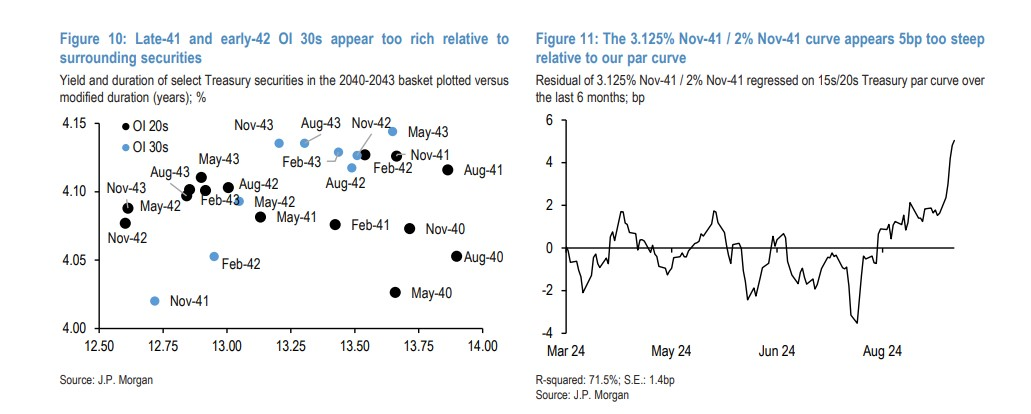

In [13]:
import sys

sys.path.append("../../")

In [14]:
from CurveInterpolator import GeneralCurveInterpolator
from CurveDataFetcher import CurveDataFetcher
from utils.rv_utils import cusip_spread_rv_regression
from utils.viz import plot_usts
from models.calibrate import calibrate_mles_ols, calibrate_nss_ols
from models.NelsonSiegelSvensson import NelsonSiegelSvenssonCurve

In [15]:
import pandas as pd
import numpy as np
import scipy
from datetime import datetime
from typing import Dict, List
import tqdm

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {
    "axes.titlesize": "x-large",
    "legend.fontsize": "x-large",
    "axes.labelsize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)

import seaborn as sns
sns.set(style="whitegrid", palette="dark")

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

import plotly
plotly.offline.init_notebook_mode()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True)

In [17]:
quote_type = "eod"
as_of_date = datetime(2024, 9, 20)

curve_set_df = curve_data_fetcher.build_curve_set(
    as_of_date=as_of_date,
    sorted=True,
    include_off_the_run_number=True,
    market_cols_to_return=[f"{quote_type}_price", f"{quote_type}_yield"],
    calc_free_float=True,
    use_github=True,
)

curve_set_df

cusip security_type auction_date issue_date maturity_date  \
0    912797LJ4          Bill   2024-08-22 2024-08-27    2024-09-24   
1    912797LK1          Bill   2024-08-29 2024-09-03    2024-10-01   
2    912797LS4          Bill   2024-09-05 2024-09-10    2024-10-08   
3    912797LT2          Bill   2024-09-12 2024-09-17    2024-10-15   
4    912797LU9          Bill   2024-08-22 2024-08-27    2024-10-22   
..         ...           ...          ...        ...           ...   
388  912810TT5          Bond   2023-10-12 2023-10-16    2053-08-15   
389  912810TV0          Bond   2024-01-11 2024-01-16    2053-11-15   
390  912810TX6          Bond   2024-04-11 2024-04-15    2054-02-15   
391  912810UA4          Bond   2024-07-11 2024-07-15    2054-05-15   
392  912810UC0          Bond   2024-09-12 2024-09-16    2054-08-15   

     time_to_maturity  int_rate  high_investment_rate is_on_the_run  \
0            0.010959       NaN                 5.335         False   
1            0.030137       NaN                 5.263         False   
2            0.049315       NaN                 5.171         False   
3            0.068493       NaN                 5.053          True   
4            0.087671       NaN                 5.238         False   
..                ...       ...                   ...           ...   
388         28.920548     4.125                   NaN         False   
389         29.172603     4.750                   NaN         False   
390         29.424658     4.250                   NaN         False   
391         29.668493     4.625                   NaN         False   
392         29.920548     4.250                   NaN          True   

         ust_label  ...      parValue percentOutstanding  est_outstanding_amt  \
0    5.335% Sep-24  ...  7.426366e+08           0.003085         2.407091e+11   
1    5.263% Oct-24  ...  7.639260e+08           0.003311         2.307445e+11   
2    5.171% Oct-24  ...  7.725101e+08           0.003348         2.307550e+11   
3    5.053% Oct-24  ...  7.980483e+08           0.003458         2.307985e+11   
4    5.238% Oct-24  ...  4.965473e+08           0.003300         1.504905e+11   
..             ...  ...           ...                ...                  ...   
388  4.125% Aug-53  ...  8.606596e+09           0.120247         7.157430e+10   
389  4.750% Nov-53  ...  4.567153e+08           0.006874         6.644364e+10   
390  4.250% Feb-54  ...  2.211754e+09           0.031064         7.119879e+10   
391  4.625% May-54  ...  7.428279e+09           0.097202         7.642080e+10   
392  4.250% Aug-54  ...  4.964611e+09           0.095537         5.196507e+10   

     corpus_cusip outstanding_amt  portion_unstripped_amt  \
0             NaN    0.000000e+00                     NaN   
1             NaN    0.000000e+00                     NaN   
2             NaN    0.000000e+00                     NaN   
3             NaN    0.000000e+00                     NaN   
4             NaN    0.000000e+00                     NaN   
..            ...             ...                     ...   
388     912803GU1    7.157430e+10              60954881.0   
389     912803GW7    6.644364e+10              56812091.9   
390     912803GY3    7.119879e+10              58204025.7   
391     912803HB2    7.642080e+10              68393441.8   
392     912803HD8    2.975507e+10              29061214.1   

     portion_stripped_amt  reconstituted_amt  free_float  rank  
0            0.000000e+00                NaN   -742.6366  16.0  
1            0.000000e+00                NaN   -763.9260  15.0  
2            0.000000e+00                NaN   -772.5101  14.0  
3            0.000000e+00                NaN   -798.0483  13.0  
4            0.000000e+00                NaN   -496.5473  12.0  
..                    ...                ...         ...   ...  
388          1.061942e+10           991450.0  52348.2848   4.0  
389          9.631553e+09          1679110.0  56355.3766   3.0  
390          1.299477e+1

## Build Par Curve Model

In [18]:
def liquidity_premium_curve_set_filter(curve_set_df: pd.DataFrame):

    # remove OTRs, olds, double olds, triple olds
    curve_set_filtered_df = curve_set_df[
        (curve_set_df["rank"] != 0) & (curve_set_df["rank"] != 1) & (curve_set_df["rank"] != 2) & (curve_set_df["rank"] != 3)
    ]

    # remove TBills
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["security_type"] != "Bill"]

    # remove low free float bonds (< $5bn)
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["free_float"] > 5000]

    # filter out bonds very close to maturity
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["time_to_maturity"] > 30 / 360]

    # remove CTDs
    curve_set_filtered_df = curve_set_filtered_df[
        ~curve_set_filtered_df["cusip"].isin(
            [
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.625s 2026-09-15")["cusip"],  # TU
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.125s 2027-09-30")["cusip"],  # Z3N
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.25s 2029-02-28")["cusip"],  # FV
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.25s 2031-06-30")["cusip"],  # TY
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.375s 2034-05-15")["cusip"],  # TN
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.625s 2040-02-15")["cusip"],  # US
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.5s 2044-02-15")["cusip"],  # TWE
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.75s 2053-11-15")["cusip"],  # UL
            ]
        )
    ]

    curve_set_filtered_df = curve_set_filtered_df.sort_values(by=["time_to_maturity"])

    return curve_set_filtered_df


def no_filter(curve_set_df: pd.DataFrame):
    return curve_set_df

In [19]:
# filter and fit bspline w/ knots are liquidity points
curve_set_filtered_df = liquidity_premium_curve_set_filter(curve_set_df=curve_set_df)

filtered_fitted_interpolator = GeneralCurveInterpolator(
    x=curve_set_filtered_df["time_to_maturity"].to_numpy(),
    y=curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
)

fitted_bspline = filtered_fitted_interpolator.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25],
    k=3,
    return_func=True,
)

nss_func, status_nss, _ = calibrate_nss_ols(
    curve_set_filtered_df["time_to_maturity"].to_numpy(),
    curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
)
assert status_nss

mles_func, status_mles = calibrate_mles_ols(
    curve_set_filtered_df["time_to_maturity"].to_numpy(),
    curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
    overnight_rate=5.31,
    N=9,
)

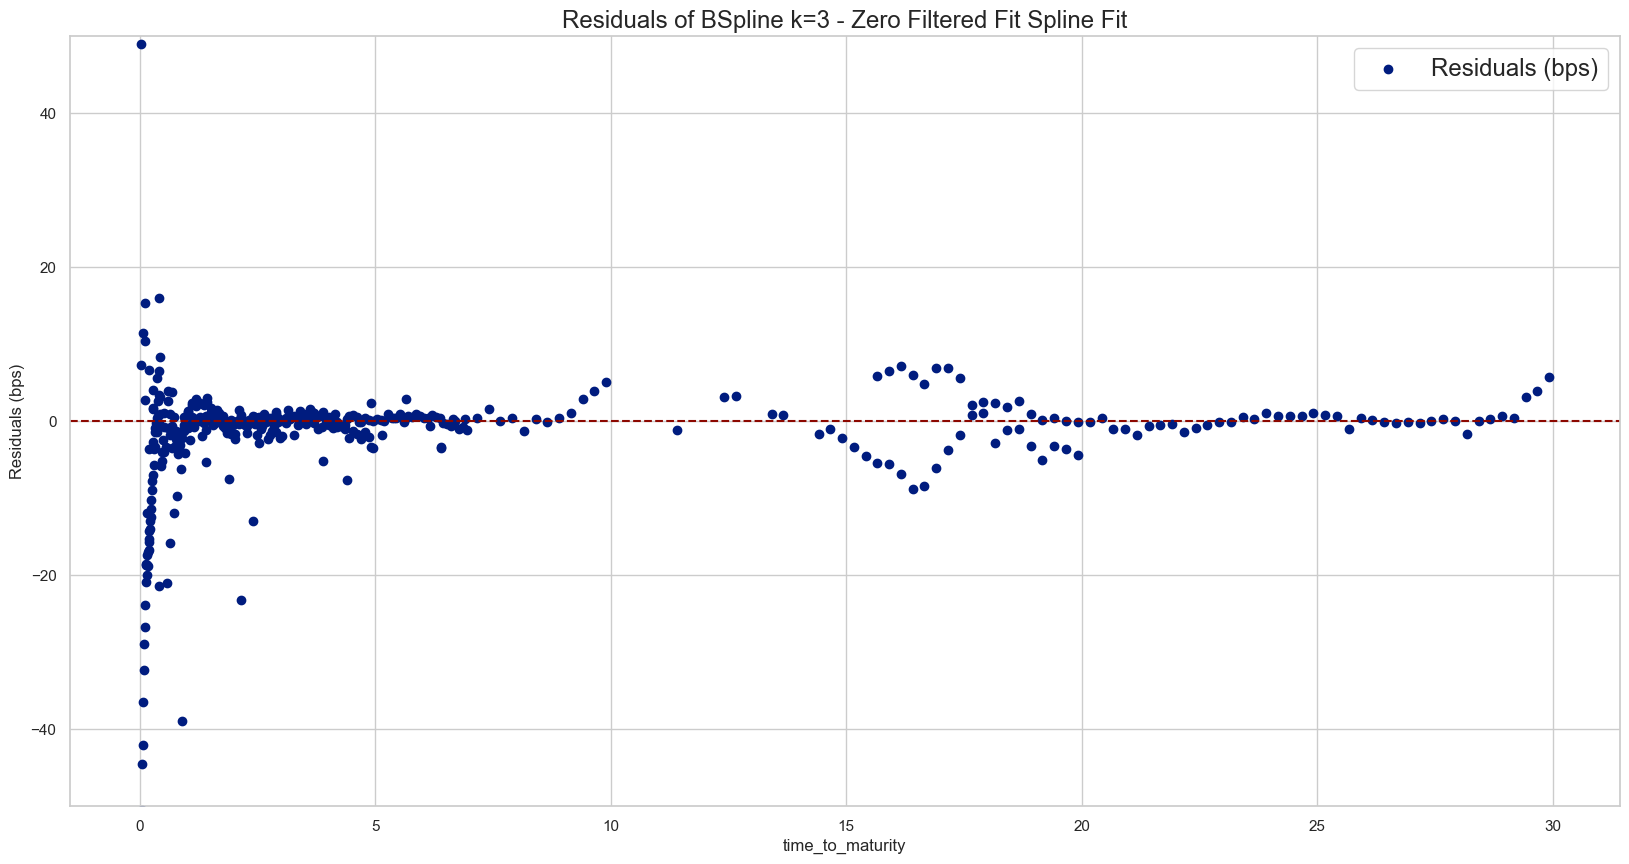

In [20]:
plot_usts(
    curve_set_df=curve_set_df,
    ttm_col="time_to_maturity",
    ytm_col=f"{quote_type}_yield",
    hover_data=[
        "issue_date",
        "maturity_date",
        "cusip",
        "original_security_term",
        "ust_label",
        f"{quote_type}_price",
        "free_float",
    ],
    ust_labels_highlighter=[
        ("3.125% Nov-41", "red"), ("2.000% Nov-41", "blue"), 
    ],
    zero_curves=[(fitted_bspline, "BSpline k=3 - Zero Filtered Fit"), (nss_func, "Nelson Siegel Svensson"), (mles_func, "Merrill Lynch Exponential Spline")],
    par_curves=[(fitted_bspline, "BSpline k=3 - Par FF",)],
    impl_spot_n_yr_fwd_curves=[(fitted_bspline, 1, "Impl Spots, 1y Fwd")],
    impl_par_n_yr_fwd_curves=[(fitted_bspline, 1, "Impl Par, 1y Fwd")],
    title=f"All USTs - using {f"{quote_type}_yield"} - as of {as_of_date}"
)

## Fetching historical curve sets to regress 3.125% Nov-41/ 2% Nov-41 flattener vs our fitted model over time

In [21]:
start_date = datetime(2024, 3, 1)
end_date = datetime(2024, 9, 20)

curve_sets_dict_df, fitted_curves_dict = curve_data_fetcher.fetch_historical_curve_sets(
    start_date=start_date,
    end_date=end_date,
    fetch_soma_holdings=True,
    fetch_stripping_data=True,
    calc_free_float=True,
    fitted_curves=[
        ("LPF", f"{quote_type}_yield", liquidity_premium_curve_set_filter),
        ("NSS", f"{quote_type}_yield", no_filter, calibrate_nss_ols),
    ],
)

AGGREGATING CURVE SET DFs: 100%|██████████| 181/181 [00:07<00:00, 22.82it/s]


### Better data structure to fetch specific CUSIP timeseries data
- Comparing different curve building methods on different filtering strats 

In [22]:
cusip_timeseries: Dict[str, List[Dict[str, str | float | int]]] = {}
fitted_cubic_spline_timeseries: Dict[datetime, scipy.interpolate] = {}
fitted_bspline_timeseries: Dict[datetime, scipy.interpolate] = {}
fitted_smooth_spline_timeseries: Dict[datetime, scipy.interpolate] = {}
nss_timeseries: Dict[datetime, NelsonSiegelSvenssonCurve] = {}

for dt in tqdm.tqdm(curve_sets_dict_df.keys(), desc="Main Loop"):
    fitted_cubic_spline = fitted_curves_dict[dt]["LPF"].b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25],
        k=3,
        return_func=True,
    )
    fitted_bspline = fitted_curves_dict[dt]["LPF"].b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 20, 25], k=5, return_func=True
    )
    fitted_smooth_spline = fitted_curves_dict[dt]["LPF"].b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 5, 7, 10, 20], k=4, return_func=True
    )
    curr_nss_model = fitted_curves_dict[dt]["NSS"]

    fitted_cubic_spline_timeseries[dt] = fitted_cubic_spline
    fitted_bspline_timeseries[dt] = fitted_bspline
    fitted_smooth_spline_timeseries[dt] = fitted_smooth_spline 
    nss_timeseries[dt] = curr_nss_model

    curr_curve_set_df = curve_sets_dict_df[dt]
    curr_curve_set_df["lpf_cubic_spline_spread"] = curr_curve_set_df["eod_yield"] - fitted_cubic_spline(curr_curve_set_df["time_to_maturity"])
    curr_curve_set_df["lpf_bspline_spread"] = curr_curve_set_df["eod_yield"] - fitted_bspline(curr_curve_set_df["time_to_maturity"])
    curr_curve_set_df["lpf_smooth_spline_spread"] = curr_curve_set_df["eod_yield"] - fitted_smooth_spline(curr_curve_set_df["time_to_maturity"])
    curr_curve_set_df["nf_nss_spread"] = curr_curve_set_df.apply(
        lambda row: row["eod_yield"] - curr_nss_model(row["time_to_maturity"])
        if pd.notna(row["eod_yield"]) and curr_nss_model(row["time_to_maturity"]) is not None
        else np.nan, axis=1
    )

    for _, row in curr_curve_set_df.iterrows():
        if row["cusip"] not in cusip_timeseries:
            cusip_timeseries[row["cusip"]] = []

        payload = {
            "Date": dt,
            "cusip": row["cusip"],
            f"{quote_type}_yield": row[f"{quote_type}_yield"],
            f"{quote_type}_price": row[f"{quote_type}_price"],
            "lpf_cubic_spline_spread": row["lpf_cubic_spline_spread"],
            "lpf_bspline_spread": row["lpf_bspline_spread"],
            "lpf_smooth_spline_spread": row["lpf_smooth_spline_spread"],
            "nf_nss_spread": row["nf_nss_spread"],
            "free_float": row["free_float"],
            "est_outstanding_amount": row["est_outstanding_amt"],
            "soma_holdings": row["parValue"],
            "soma_holdings_percent_outstanding": row["percentOutstanding"],
            "stripped_amount": row["portion_stripped_amt"],
            "reconstituted_amount": row["reconstituted_amt"],
            "lpf_cubic_spline": fitted_cubic_spline,
            "lpf_bspline": fitted_bspline,
            "lpf_smooth_spline": fitted_smooth_spline,
            "nf_nss": curr_nss_model,
        }
        
        cusip_timeseries[row["cusip"]].append(payload)

Main Loop: 100%|██████████| 142/142 [00:04<00:00, 31.47it/s]


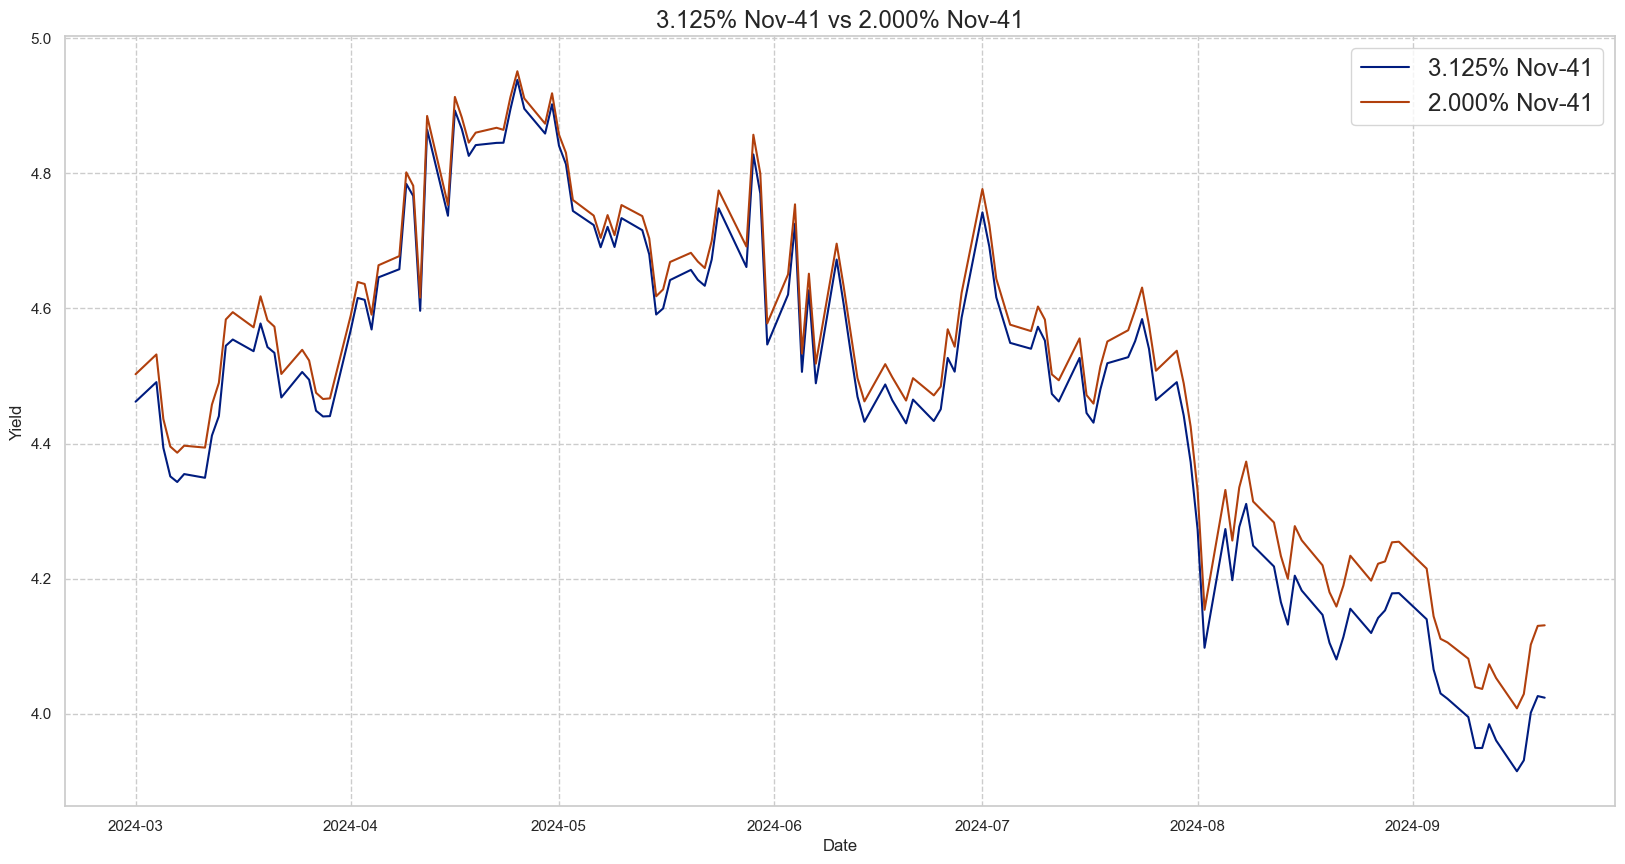

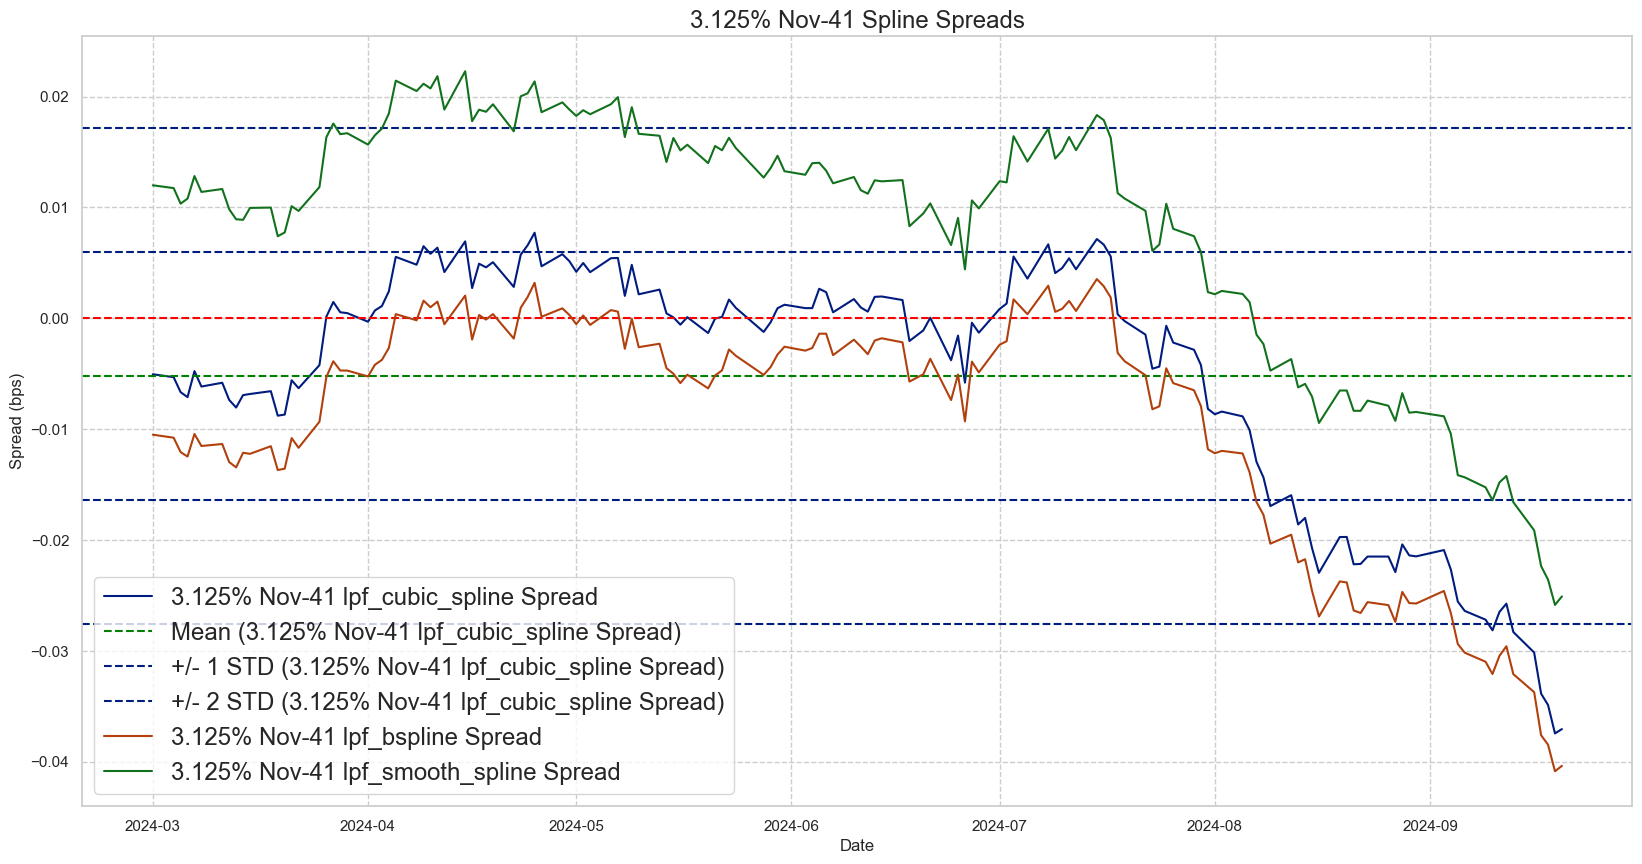

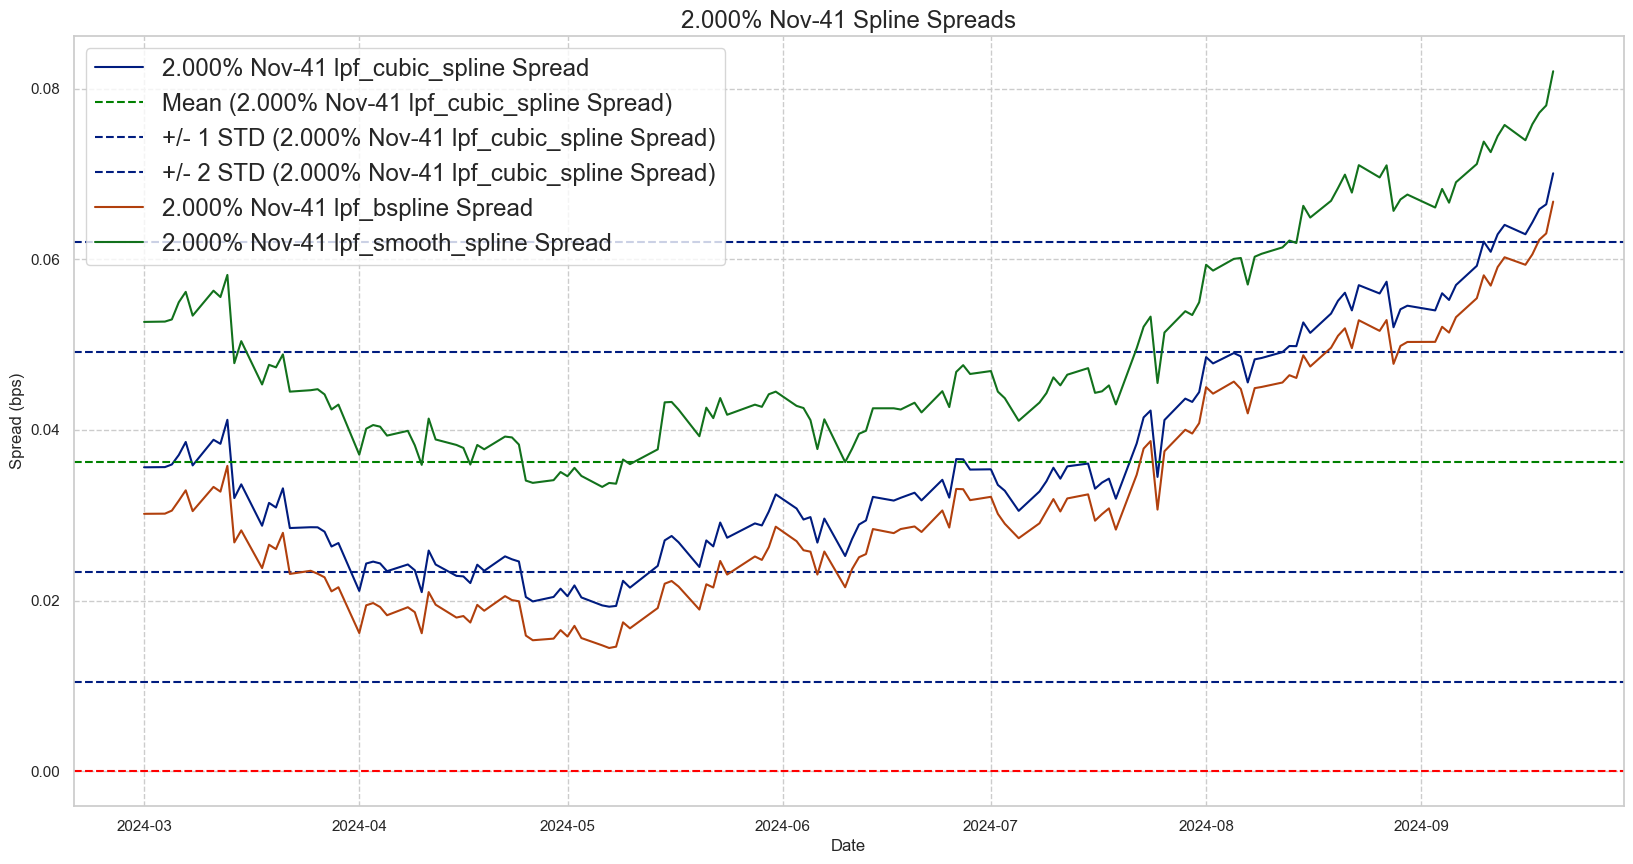

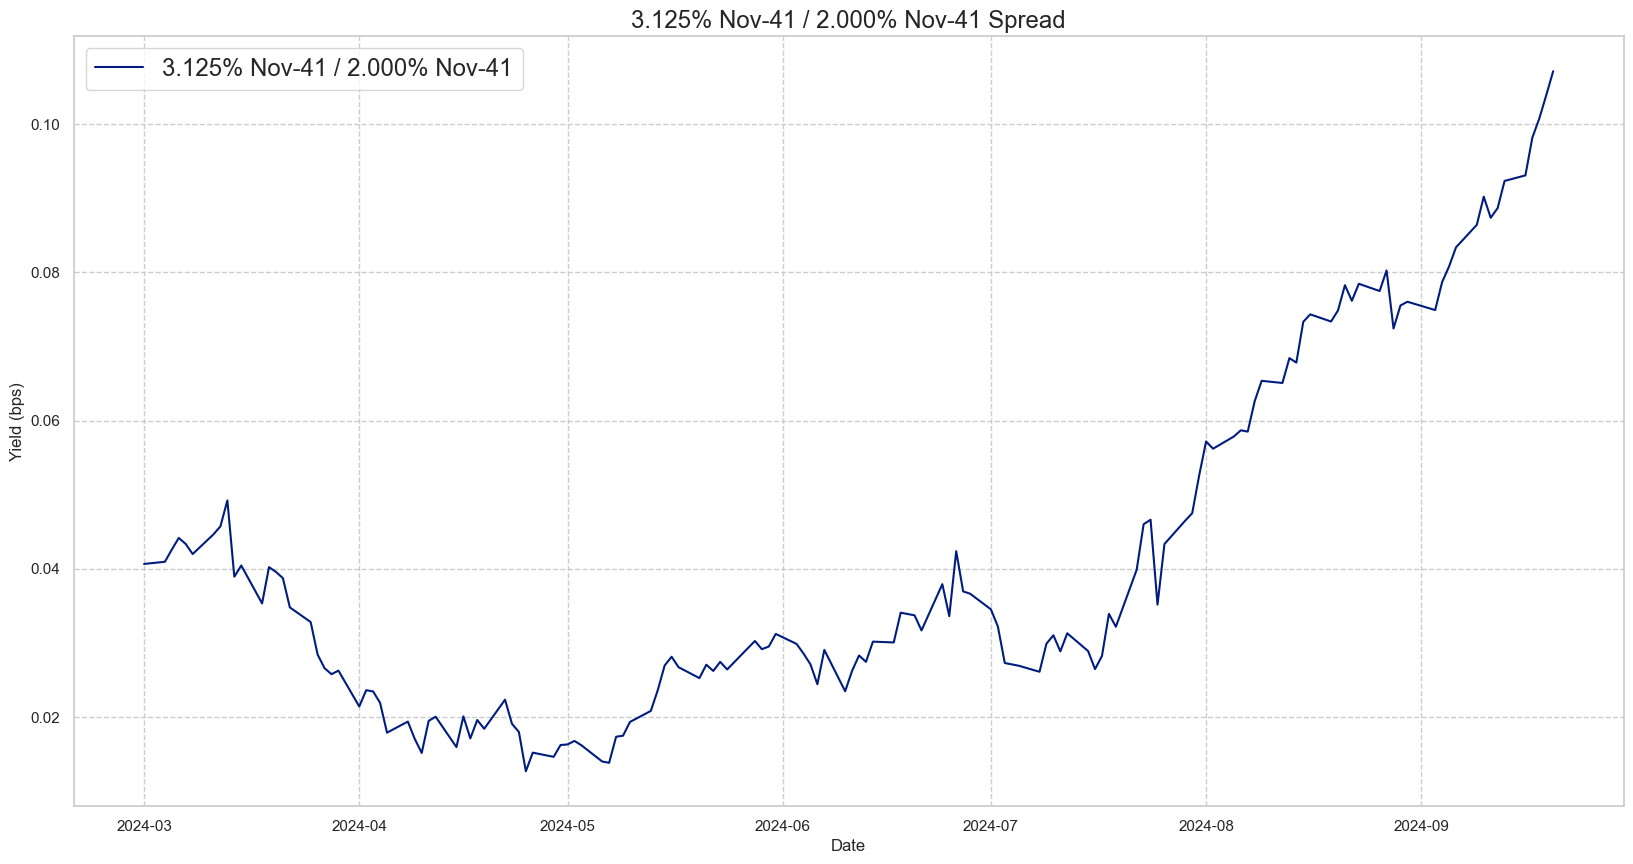

lpf_cubic_spline is Benchmark Spline


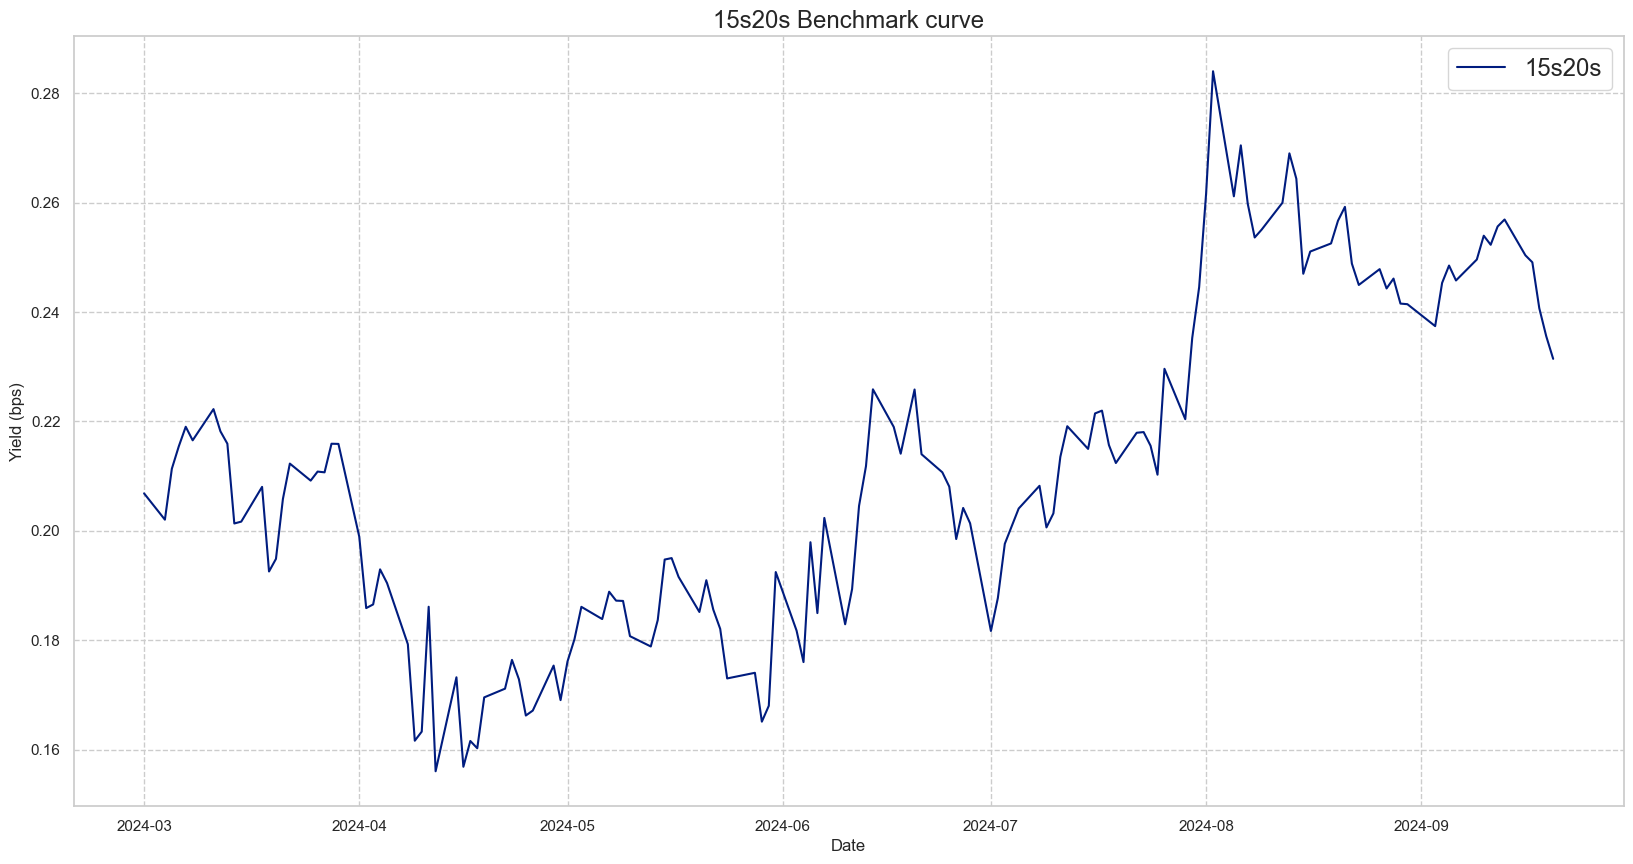

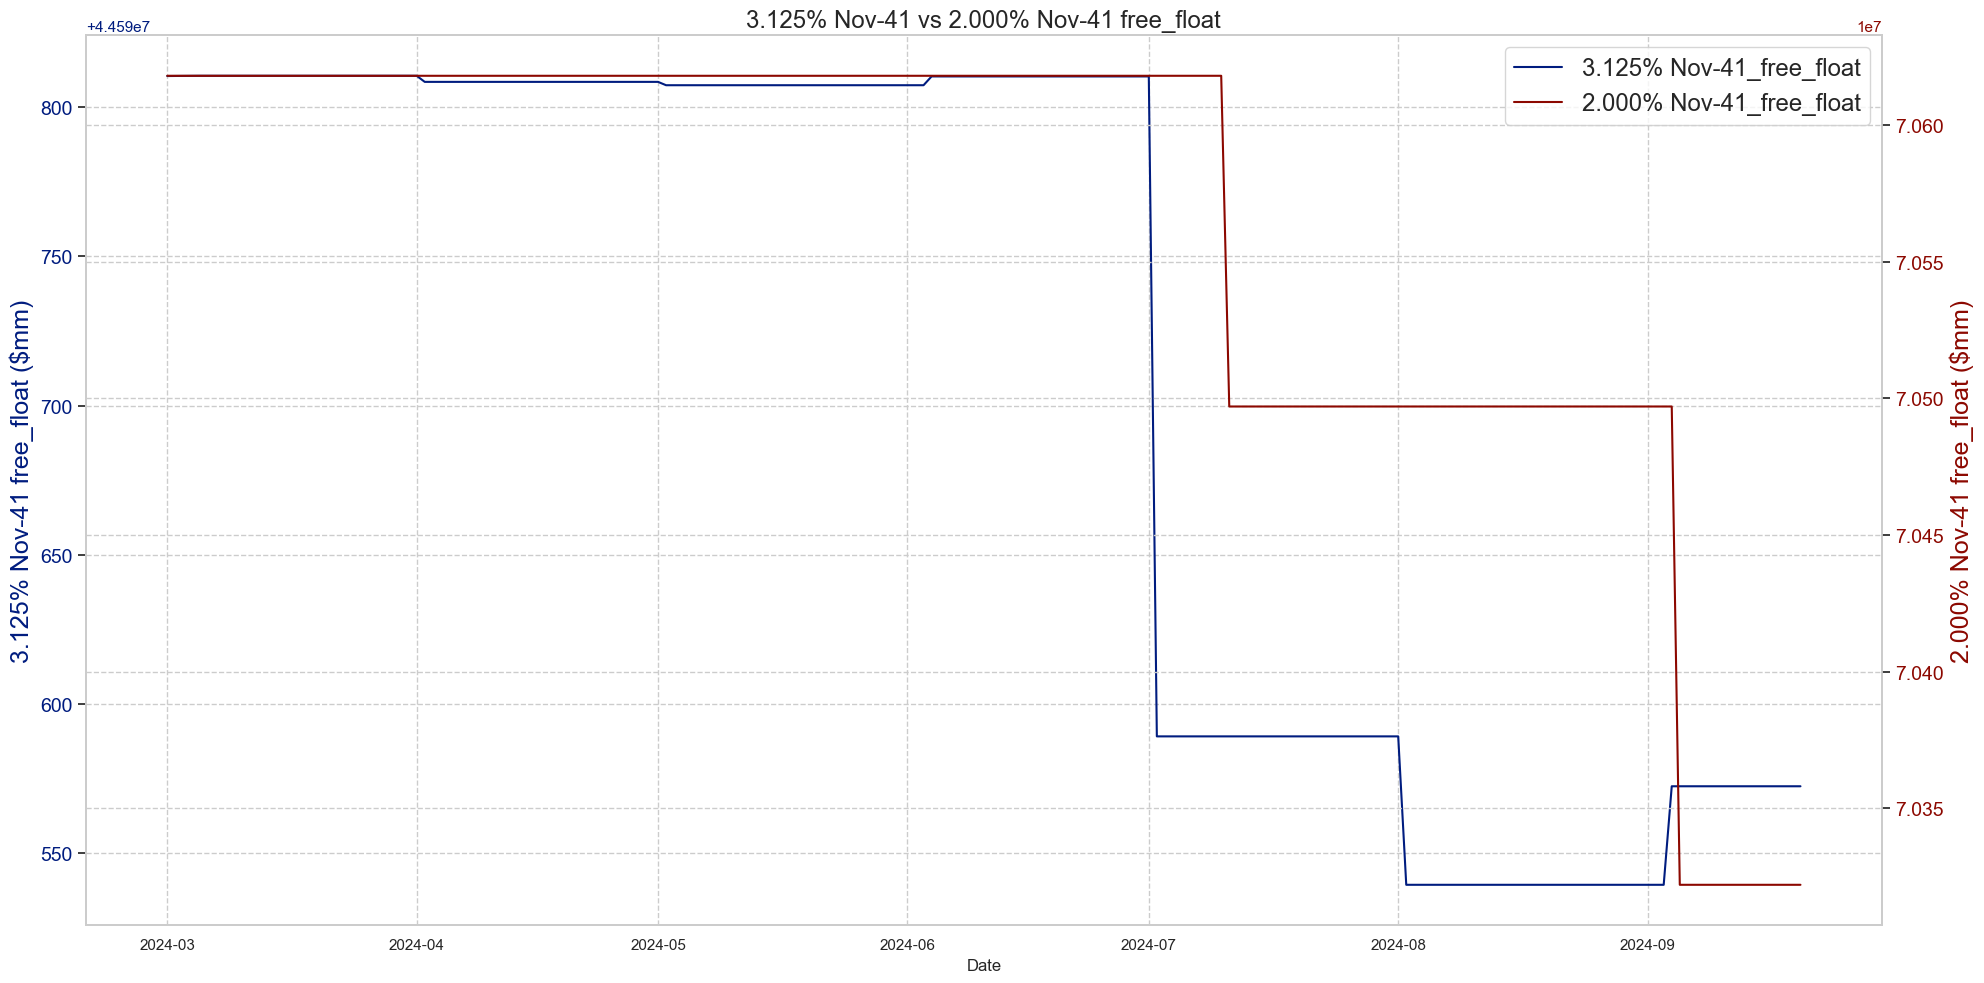

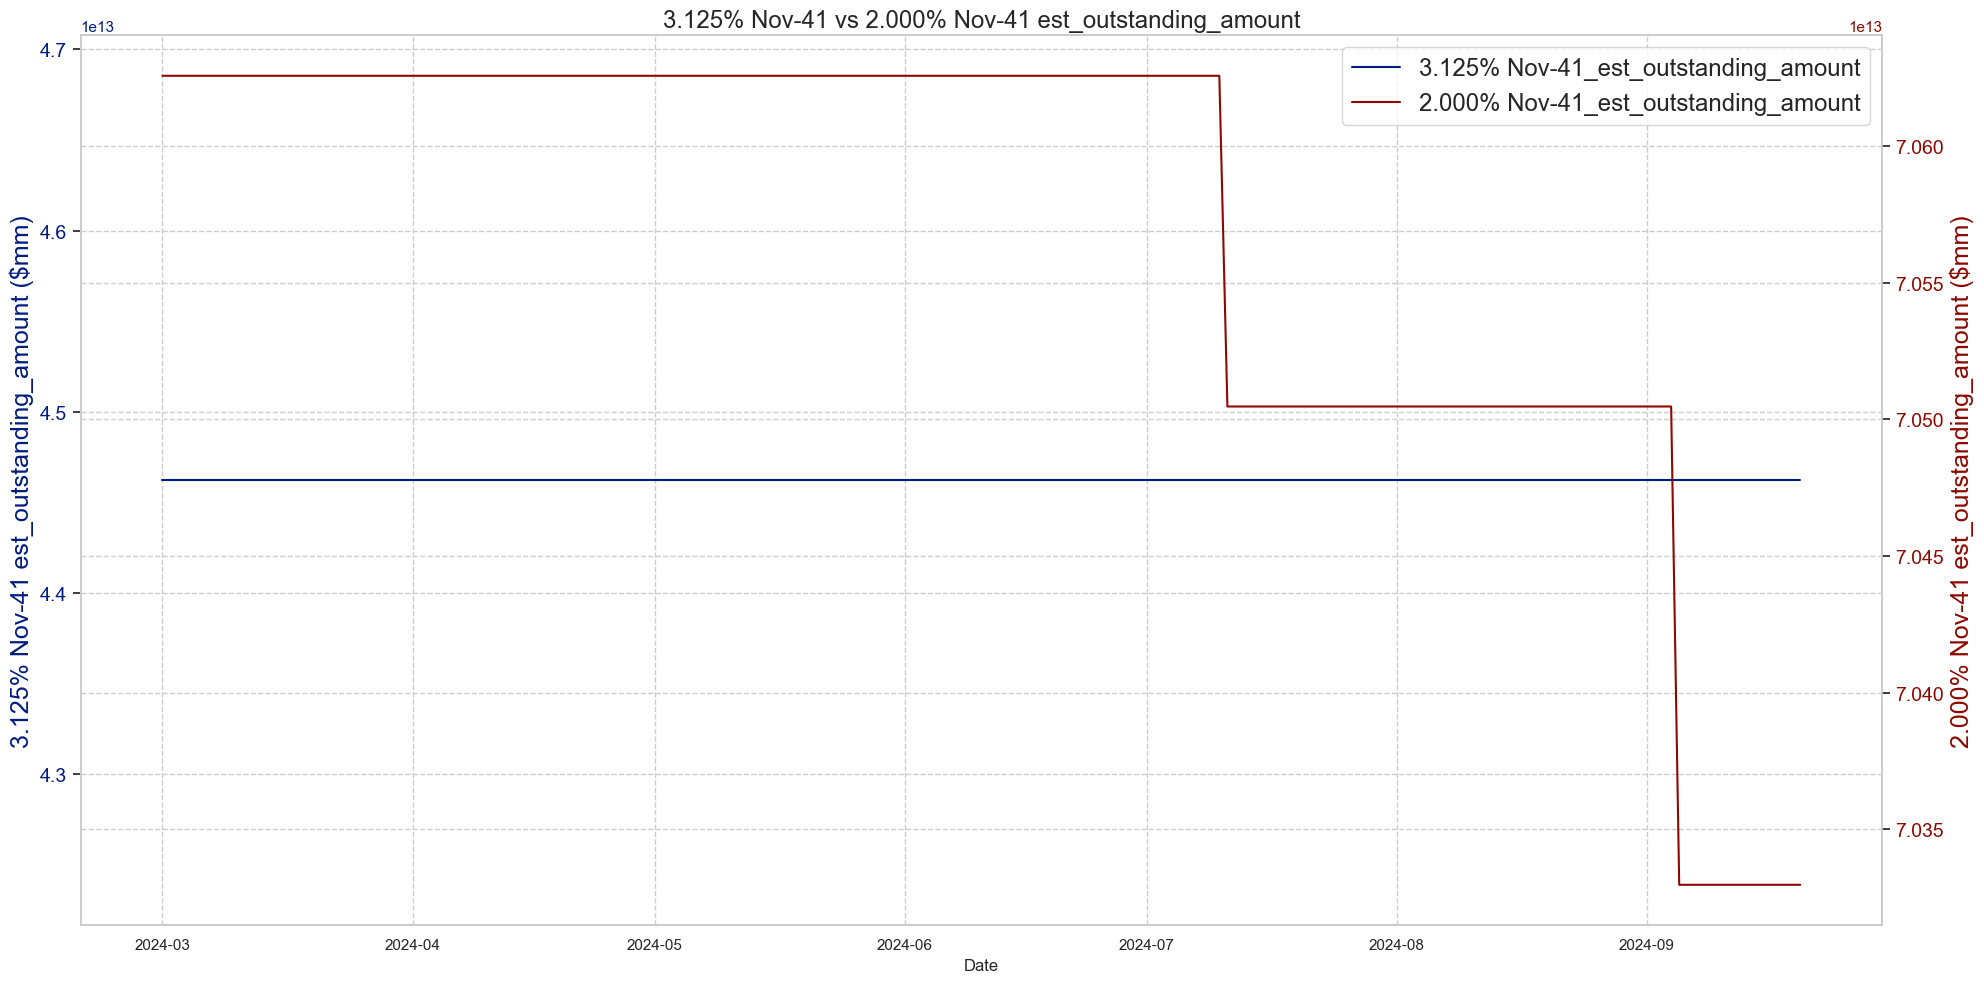

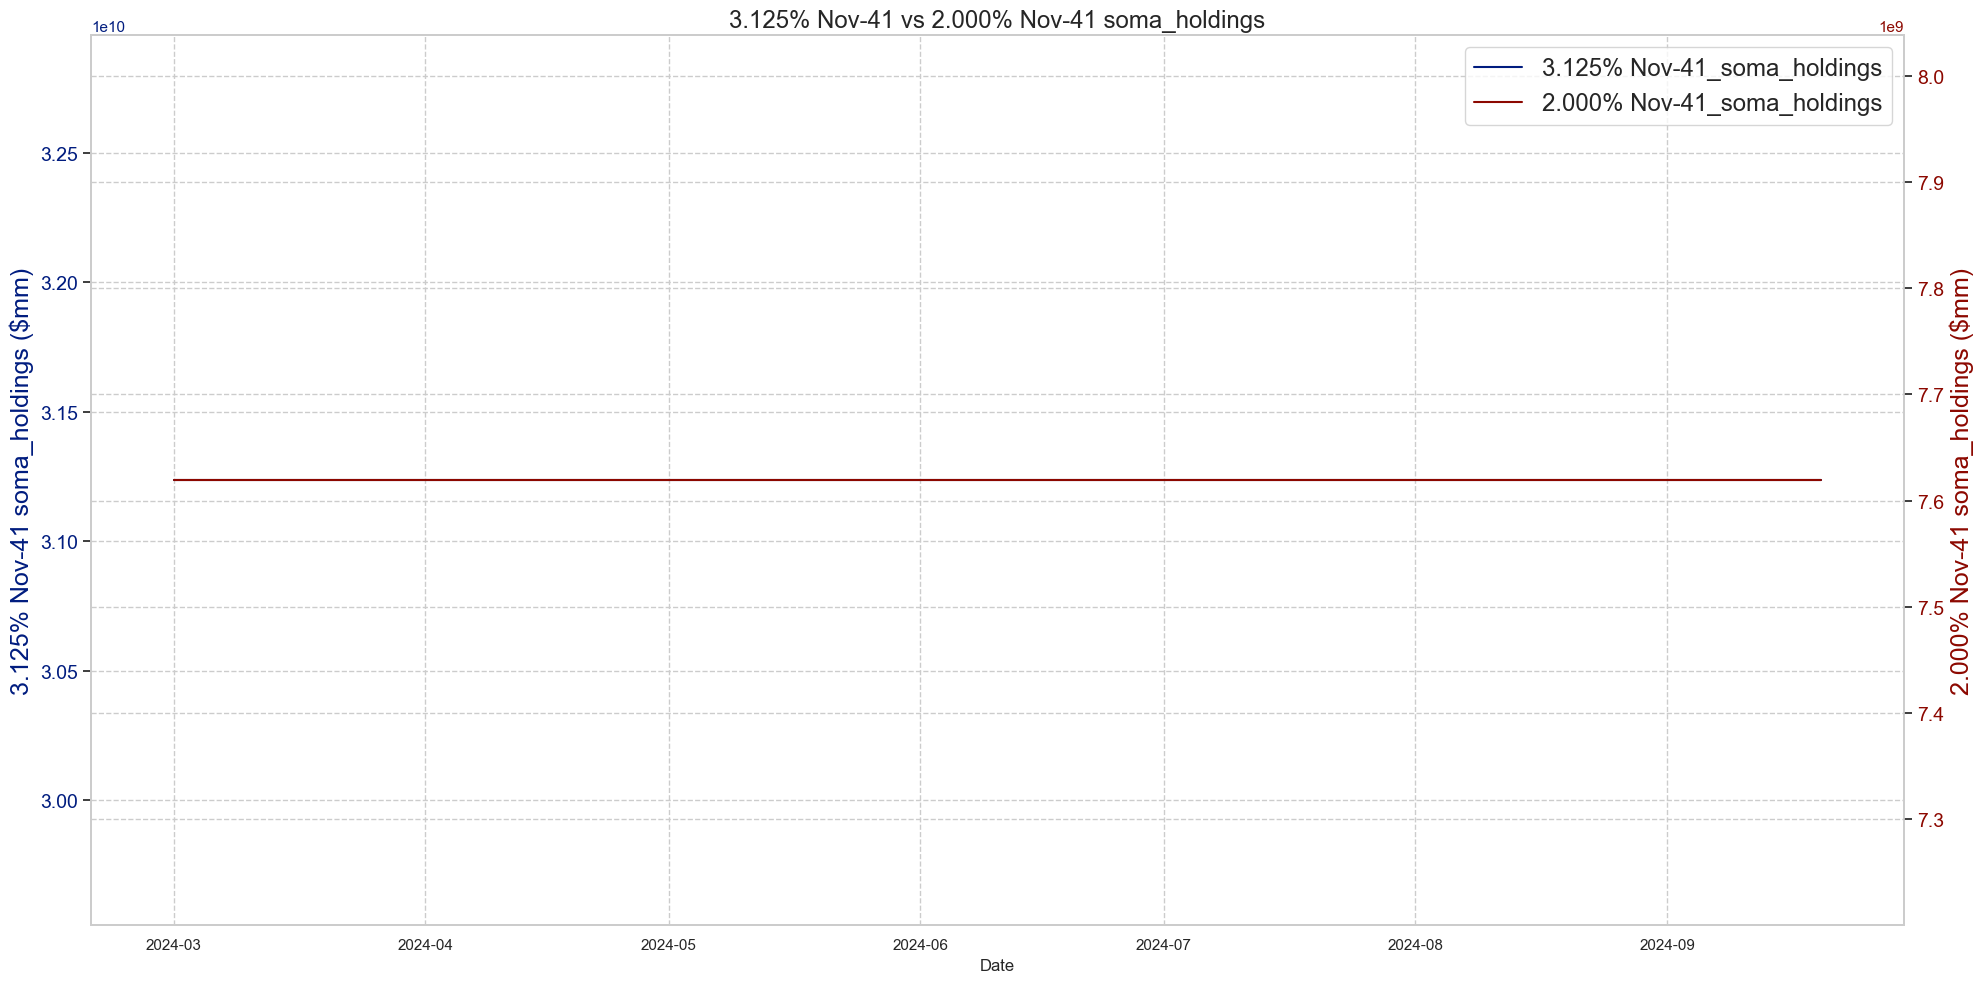

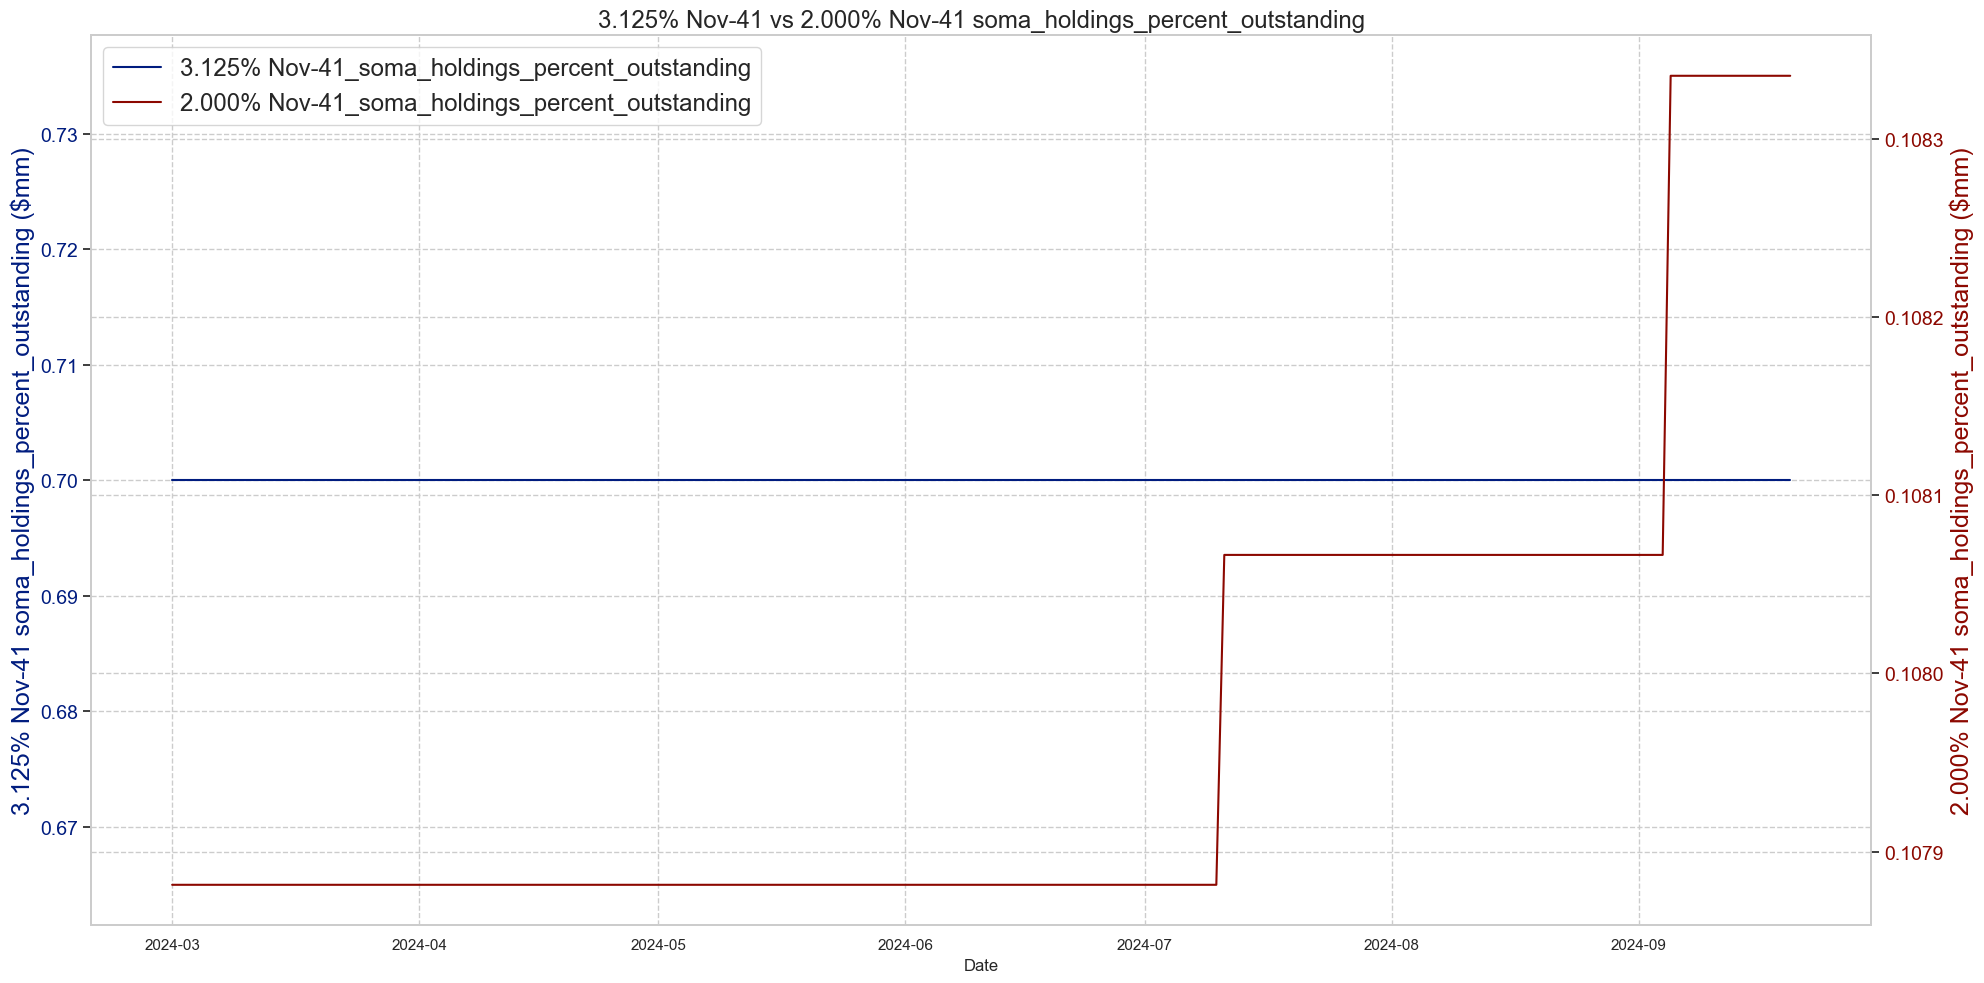

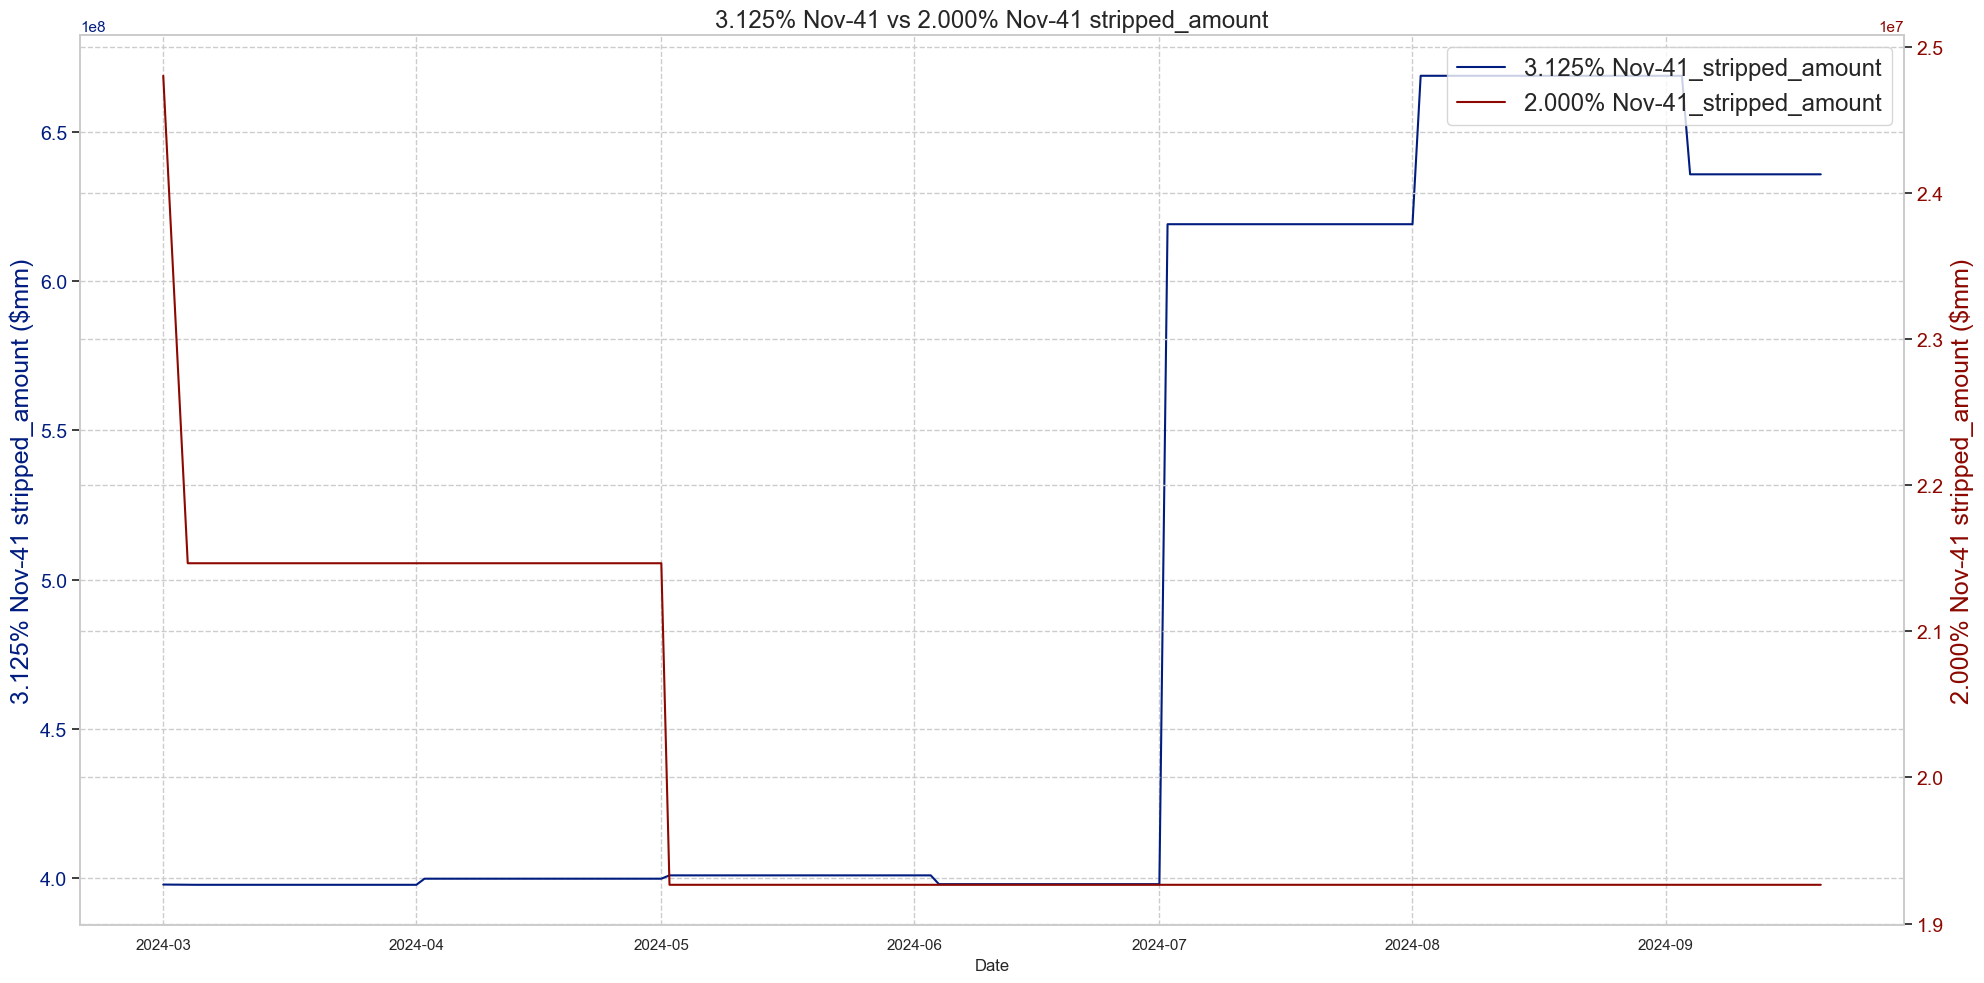

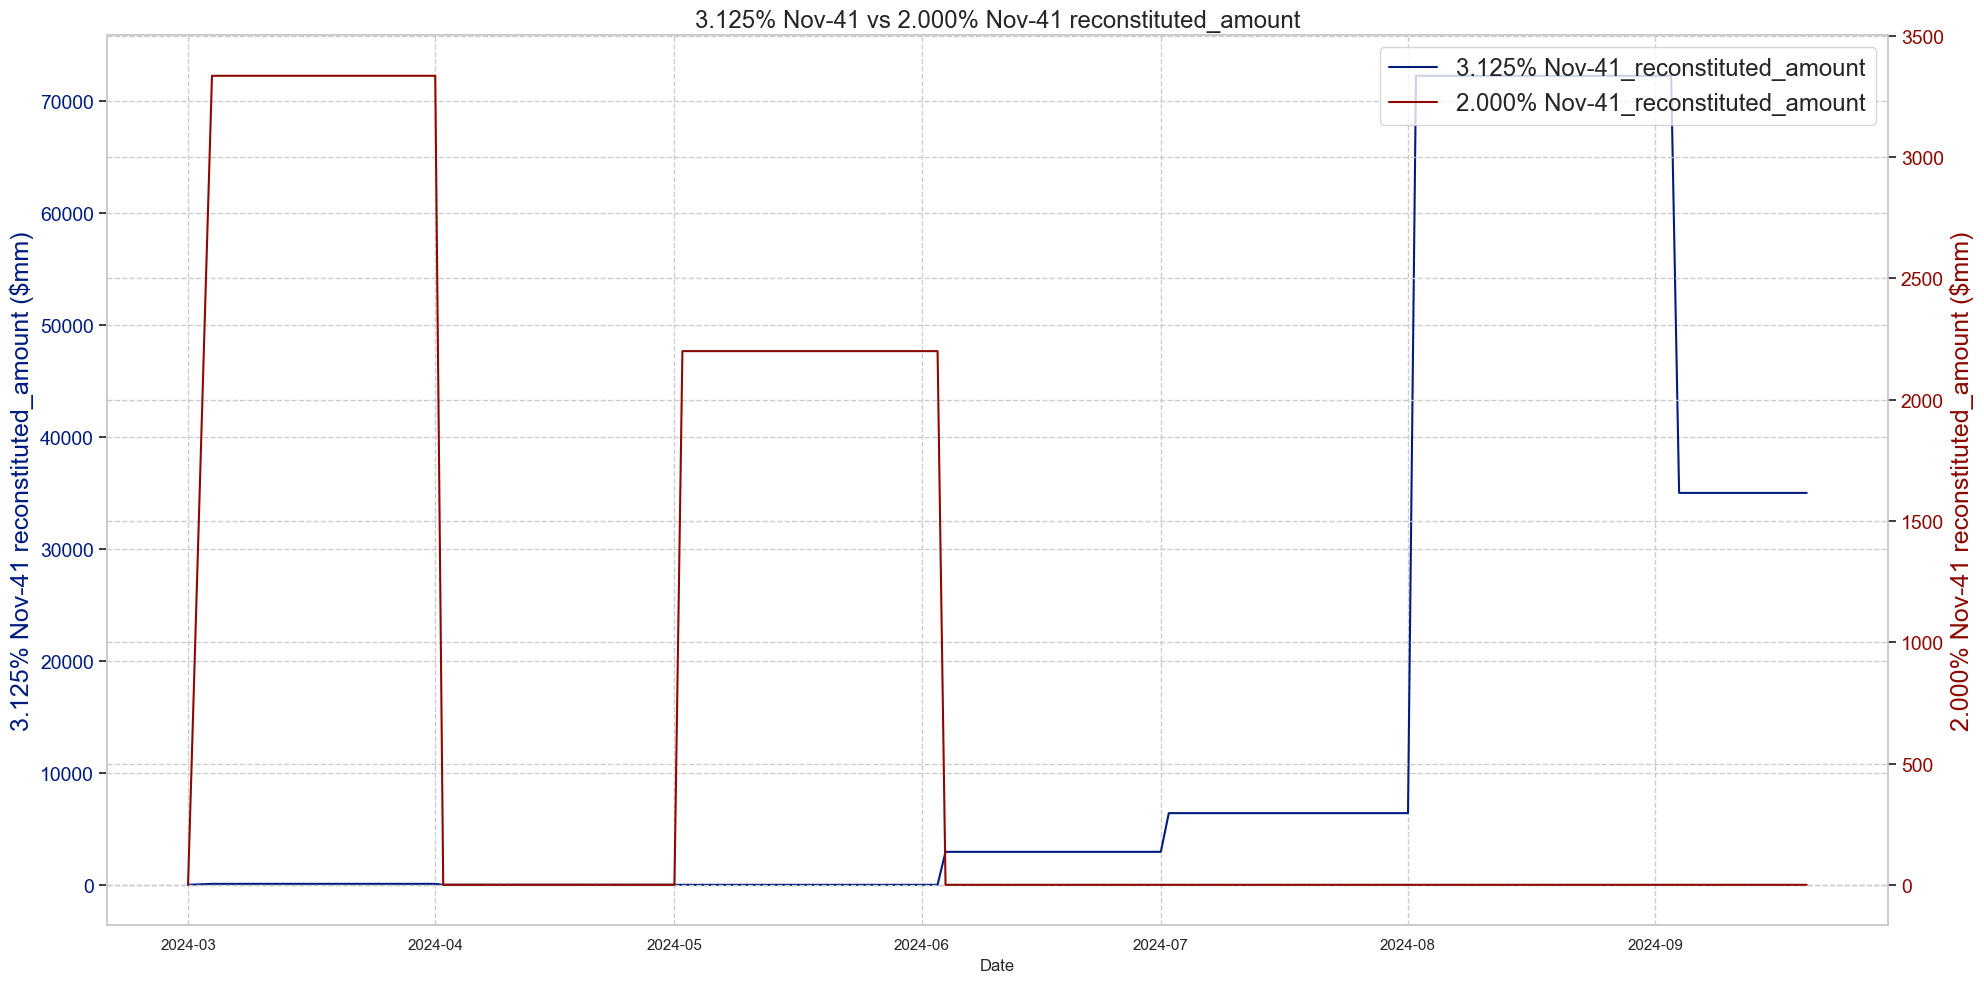

                                  OLS Regression Results                                 
Dep. Variable:     3.125% Nov-41 / 2.000% Nov-41   R-squared:                       0.697
Model:                                       OLS   Adj. R-squared:                  0.695
Method:                            Least Squares   F-statistic:                     321.6
Date:                           Sun, 06 Oct 2024   Prob (F-statistic):           4.30e-38
Time:                                   19:01:56   Log-Likelihood:                 415.41
No. Observations:                            142   AIC:                            -826.8
Df Residuals:                                140   BIC:                            -820.9
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------

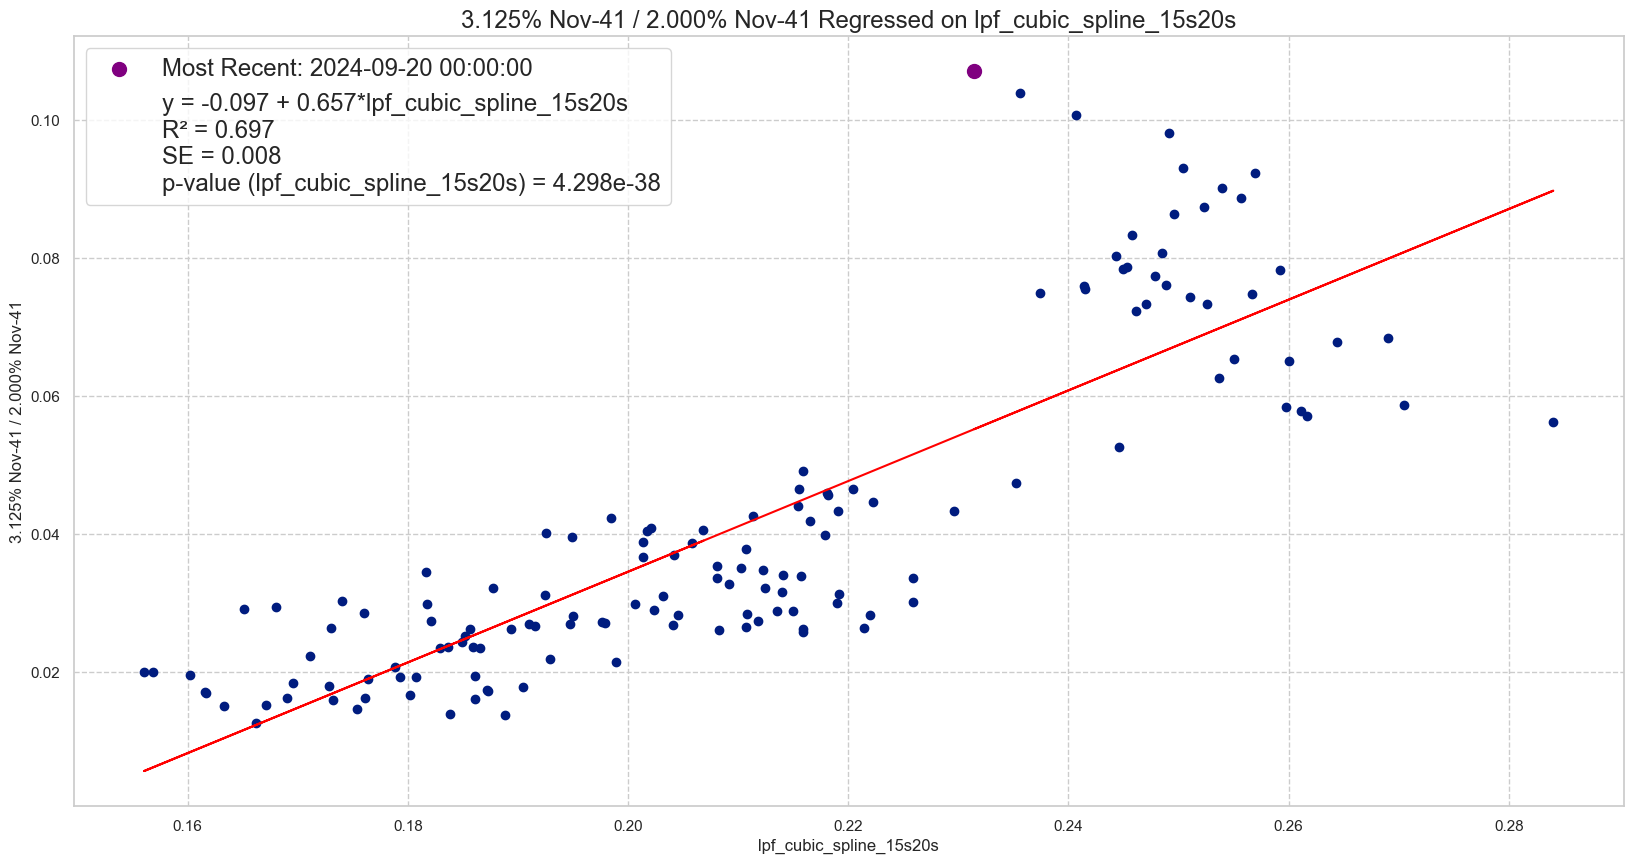

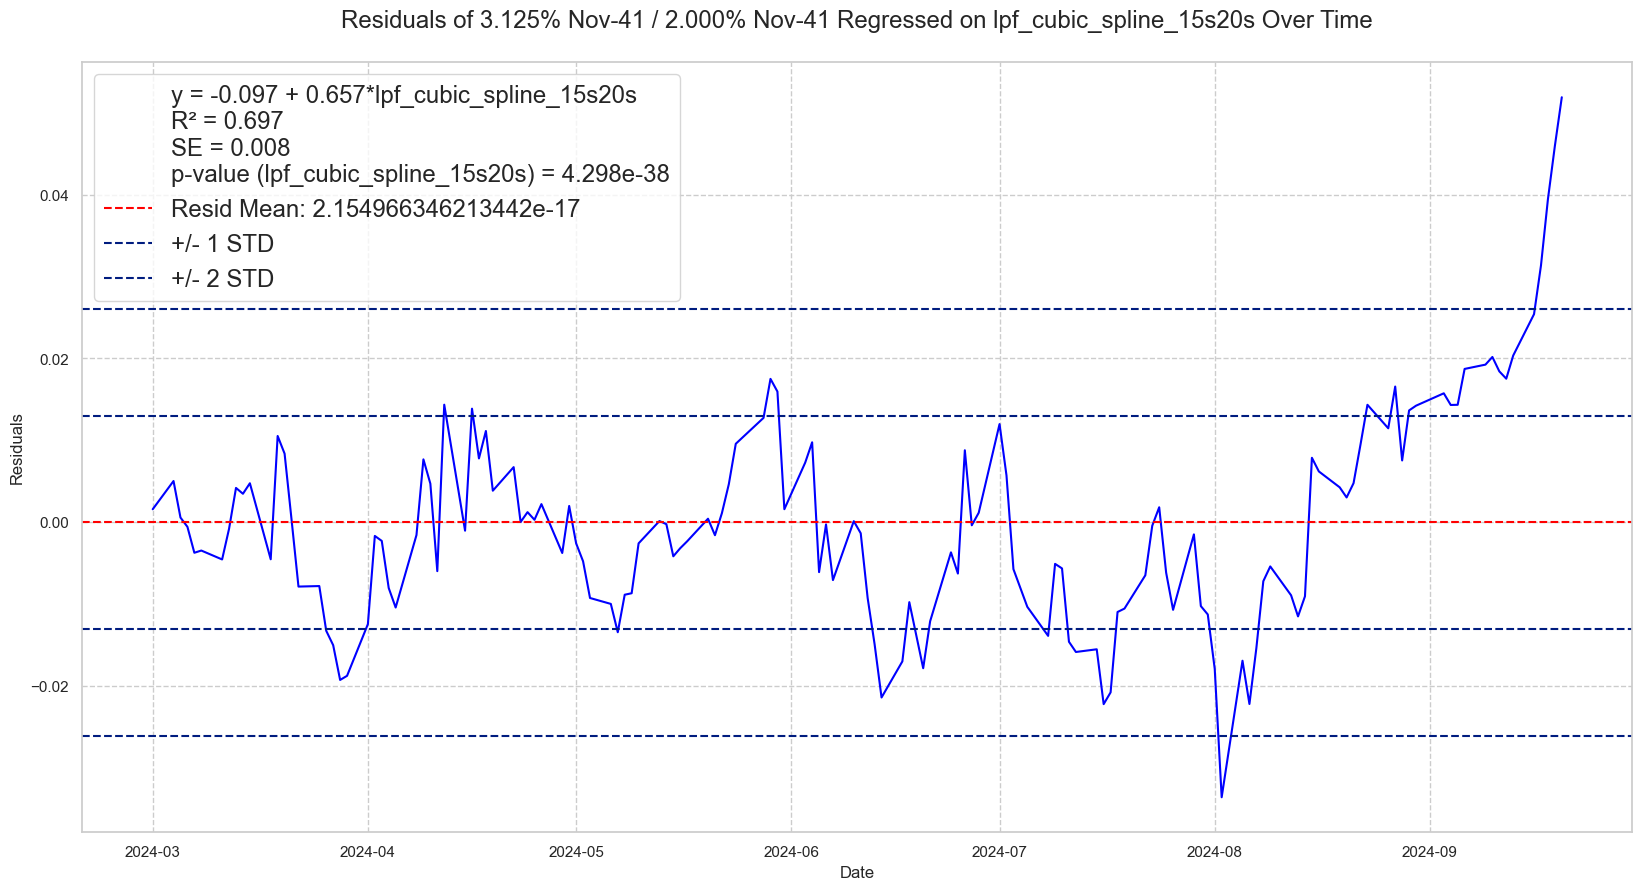

Using lpf_cubic_spline for UST Metrics Calcs


3.125% Nov-41 Metrics Calc: 142it [00:03, 36.90it/s]
2.000% Nov-41 Metrics Calc: 142it [00:03, 38.00it/s]


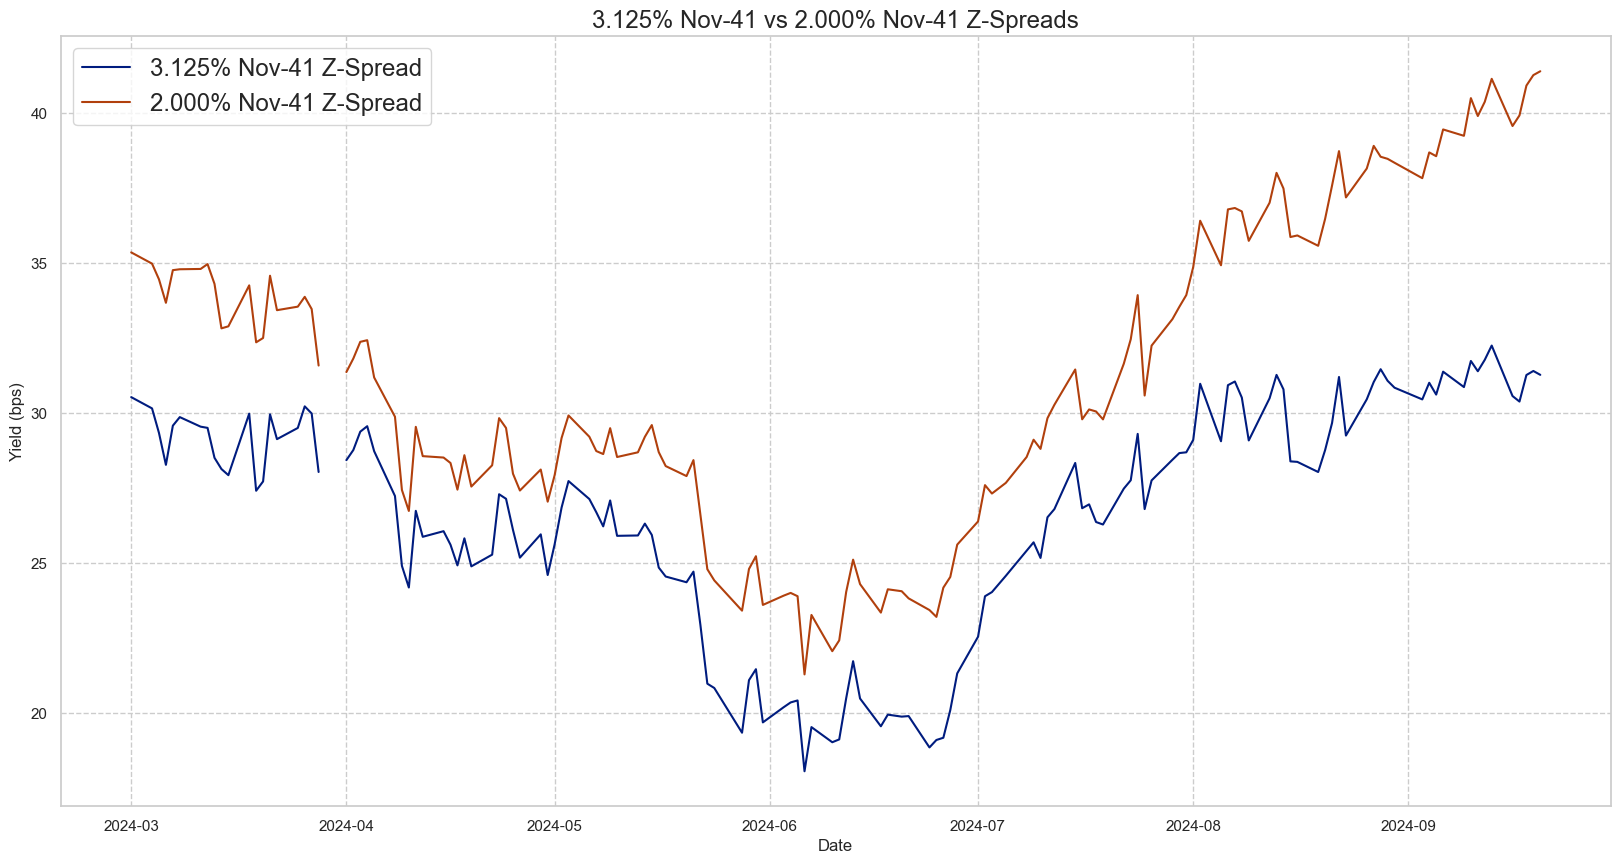

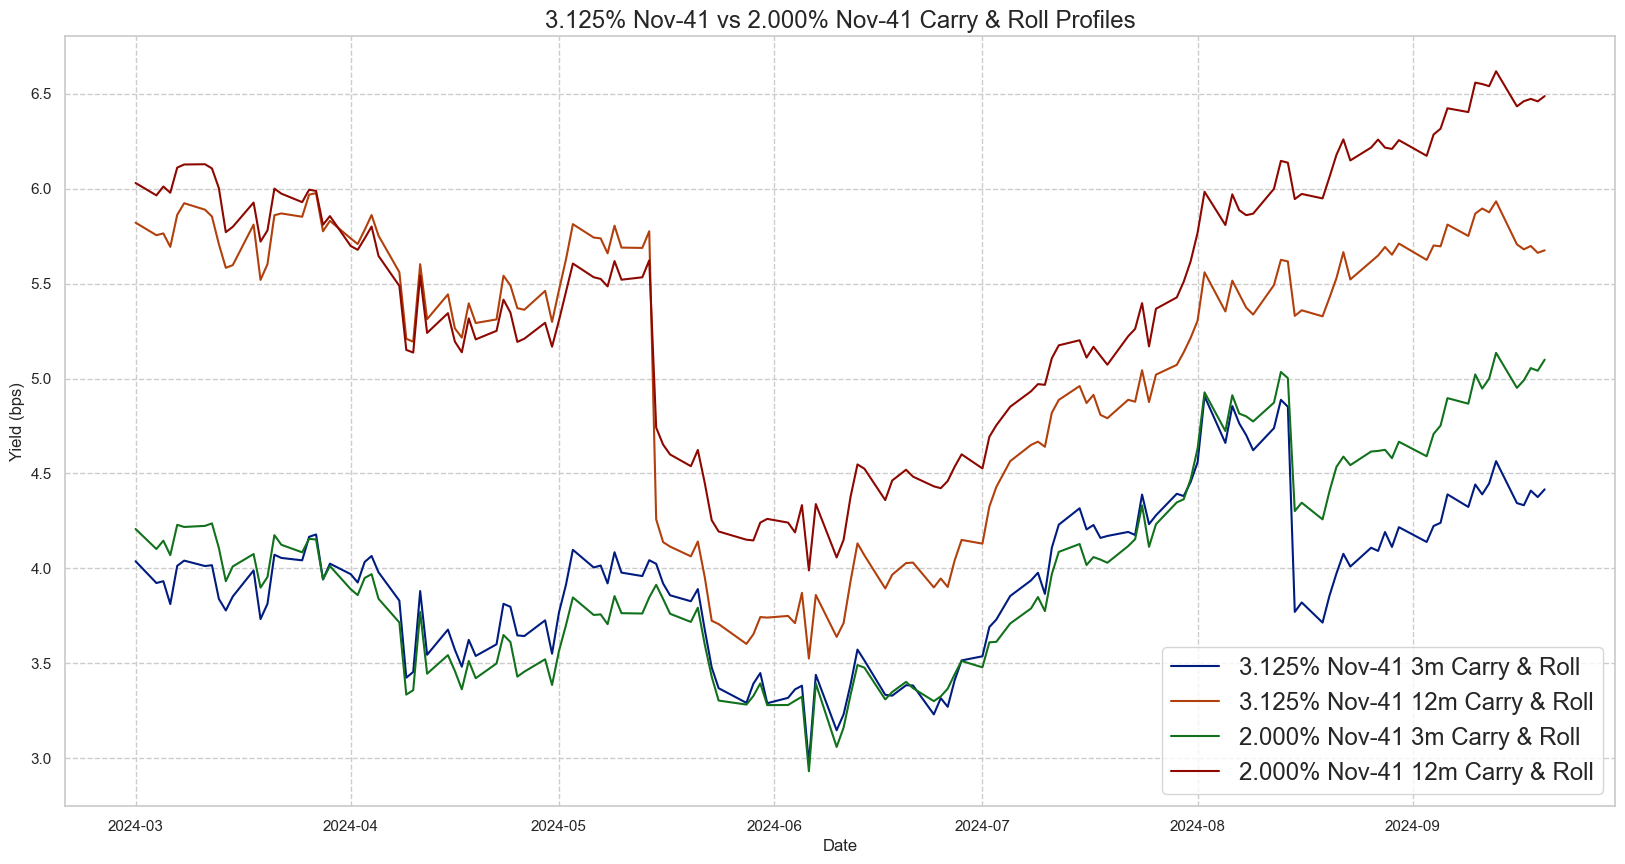

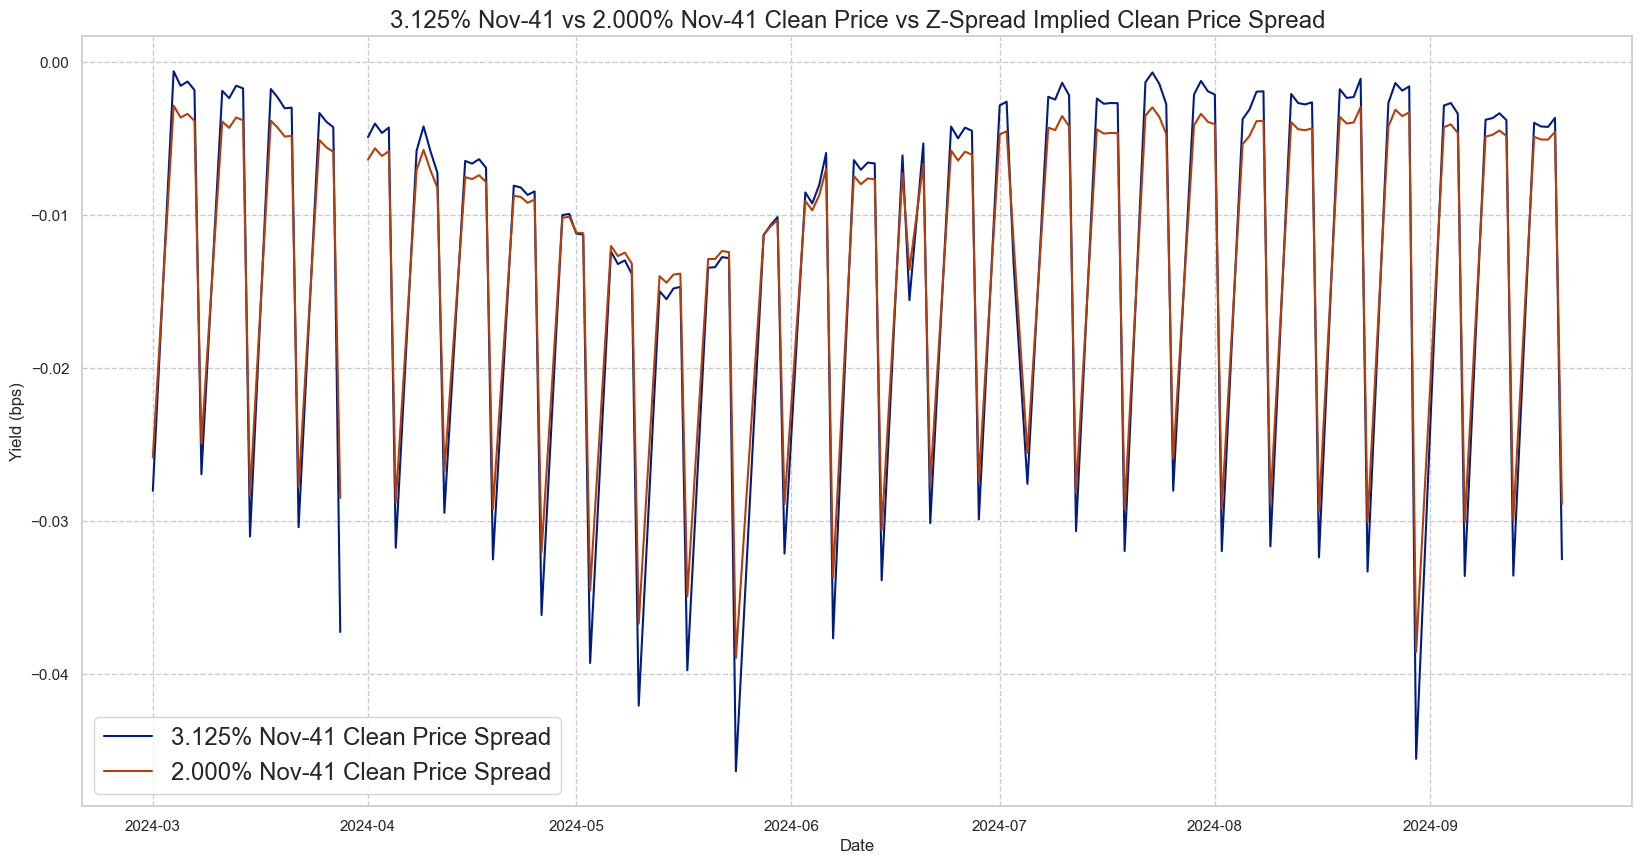

In [25]:
label1 = "3.125% Nov-41" 
label2 = "2.000% Nov-41" 

cusip_spread_rv_regression(
    curve_data_fetcher=curve_data_fetcher,
    label1=label1,
    label2=label2,
    cusip_timeseries=cusip_timeseries,
    fitted_splines_timeseries_dict={
        "lpf_cubic_spline": fitted_cubic_spline_timeseries,
        "lpf_bspline": fitted_bspline_timeseries,
        "lpf_smooth_spline": fitted_smooth_spline_timeseries,
    },
    benchmark_tenor_1=15,
    benchmark_tenor_2=20,
)